In [123]:
%reset -f 
%clear

# Importe de librerias utilizadas

In [168]:
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import joblib
%matplotlib inline

import tensorflow as tf
import tensorflow_recommenders as tfrs
import keras
from typing import Dict, Text 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Lectura del fichero y análisis

### Lectura del fichero

In [125]:
#importacion de datos 
HM = pd.read_csv('HM_interactions.csv') 

Visualización de los datos:

In [126]:
HM

,customer_id,article_id,timestamp,price,sales_channel_id
0,10054,5498,1590278400,0.033881,2
1,8612,4092,1599177600,0.013542,2
2,12973,4109,1591401600,0.013542,1
3,9820,12918,1593820800,0.045763,2
4,3329,1739,1578355200,0.011847,2
...,...,...,...,...,...
382317,12873,18345,1587772800,0.013542,2
382318,1010,11221,1590710400,0.018390,1
382319,8493,13473,1592784000,0.027102,2
382320,7232,4383,1592179200,0.008458,2


Verificamos si existen datos duplicados:

In [127]:
HM[HM.duplicated()]

,customer_id,article_id,timestamp,price,sales_channel_id
382,11819,14350,1592956800,0.025407,2
396,4073,7335,1600560000,0.016525,2
3485,1065,14789,1583280000,0.030492,2
5150,2091,326,1584835200,0.033881,2
5606,9110,11246,1590192000,0.016932,2
...,...,...,...,...,...
382294,10062,1662,1585612800,0.016932,2
382301,10633,6250,1598659200,0.033881,2
382304,5752,15933,1586217600,0.025407,2
382317,12873,18345,1587772800,0.013542,2


Podemos observar que existensí registros duplicados en términos de usuario, artículo, fecha y precio. Por lo tanto, se considera que esto se debe limpiar:

In [128]:
HM = HM.drop_duplicates().reset_index( drop=True)

### Análisis de los datos

Observamos la cantidad de ventas de los artículos. Se puede apreciar que existen artículos que se han comprado pocas veces. Por lo tanto, se opta por realizar una limpieza de estos artículos ya que se considera que distorcionarían el entrenamiento de la red neuronal.

In [129]:
art_cant = HM['article_id'].value_counts()
art_cant

3872     394
5988     361
1806     309
13645    297
1805     295
        ... 
4172       1
2101       1
1514       1
10148      1
9505       1
Name: article_id, Length: 21475, dtype: int64

In [130]:
art_cant.describe()

count    21475.000000
mean        16.930291
std         21.887597
min          1.000000
25%          5.000000
50%          9.000000
75%         20.000000
max        394.000000
Name: article_id, dtype: float64

(0.0, 100.0)

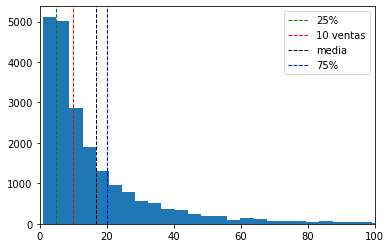

In [131]:
plt.hist(art_cant, bins=100)
plt.axvline(np.quantile(art_cant, 0.25), color='green', linestyle='dashed', linewidth=1, label = "25%")
plt.axvline(10, color='red', linestyle='dashed', linewidth=1,  label = "10 ventas" )
plt.axvline(art_cant.mean(), color='black', linestyle='dashed', linewidth=1, label = "media")
plt.axvline(np.quantile(art_cant, 0.75), color='blue', linestyle='dashed', linewidth=1, label = "75%")
plt.legend(loc="upper right")
plt.xlim([0, 100])

A continuación, se observan los usuarios que han realizado compras:

In [132]:
cust_cant = HM['customer_id'].value_counts()
cust_cant

9568     216
9990     190
3491     173
9494     156
8805     150
        ... 
5096       4
10172      4
1065       3
11717      3
7468       1
Name: customer_id, Length: 13359, dtype: int64

(0.0, 100.0)

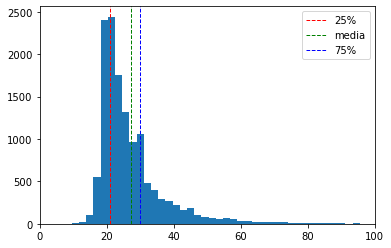

In [133]:
plt.hist(cust_cant, bins=100)
plt.axvline(np.quantile(cust_cant, 0.25), color='red', linestyle='dashed', linewidth=1, label = "25%")
plt.axvline(cust_cant.mean(), color='green', linestyle='dashed', linewidth=1, label = "media")
plt.axvline(np.quantile(cust_cant, 0.75), color='blue', linestyle='dashed', linewidth=1, label = "75%")
plt.legend(loc="upper right")
plt.xlim([0, 100])

### Train set y Test set

A continuación, se ordenan los valores por usuario y por fecha:

In [134]:
#verificación
HM_sorted = HM.sort_values(by=['customer_id', 'timestamp'], ascending=[True, True])
HM_sorted.reset_index()

,index,customer_id,article_id,timestamp,price,sales_channel_id
0,358129,0,1806,1578441600,0.007881,2
1,61181,0,6180,1582502400,0.044966,2
2,90940,0,11502,1582502400,0.014949,2
3,165093,0,11649,1582502400,0.044966,2
4,311039,0,16788,1582502400,0.044966,2
...,...,...,...,...,...,...
363573,286548,13358,18373,1597190400,0.033881,2
363574,198470,13358,20748,1597968000,0.027102,2
363575,172314,13358,16598,1600214400,0.005068,2
363576,227905,13358,11249,1600214400,0.016932,2


In [135]:
print(HM_sorted.nunique(), HM_sorted)

customer_id         13359
article_id          21475
timestamp             265
price                4529
sales_channel_id        2
dtype: int64         customer_id  article_id   timestamp     price  sales_channel_id
358129            0        1806  1578441600  0.007881                 2
61181             0        6180  1582502400  0.044966                 2
90940             0       11502  1582502400  0.014949                 2
165093            0       11649  1582502400  0.044966                 2
311039            0       16788  1582502400  0.044966                 2
...             ...         ...         ...       ...               ...
286548        13358       18373  1597190400  0.033881                 2
198470        13358       20748  1597968000  0.027102                 2
172314        13358       16598  1600214400  0.005068                 2
227905        13358       11249  1600214400  0.016932                 2
332634        13358       11246  1600214400  0.016932            

### Eliminación de artículos menos comprados

In [136]:
def art_mas_comprados(data, num_articles):
    article_counts = pd.DataFrame(data.article_id.value_counts().reset_index().values, columns=["article_id", "cant"])
    article_countsindex = article_counts.sort_index(axis = 0, ascending=True)
    most_bought_articles = pd.DataFrame(article_countsindex.loc[article_countsindex['cant']>=num_articles]['article_id'])
    HM_return = data.loc[data.article_id.isin(most_bought_articles.article_id)]
    return HM_return.reset_index(drop=True)


In [137]:
HM_sorted = art_mas_comprados(HM_sorted, 10)
HM_sorted

,customer_id,article_id,timestamp,price,sales_channel_id
0,0,1806,1578441600,0.007881,2
1,0,11502,1582502400,0.014949,2
2,0,16788,1582502400,0.044966,2
3,0,1367,1582502400,0.044966,2
4,0,4911,1587859200,0.040661,2
...,...,...,...,...,...
307158,13358,18373,1597190400,0.033881,2
307159,13358,20748,1597968000,0.027102,2
307160,13358,16598,1600214400,0.005068,2
307161,13358,11249,1600214400,0.016932,2


In [138]:
print(HM_sorted.nunique(),HM_sorted) 

customer_id         13359
article_id          10473
timestamp             265
price                4144
sales_channel_id        2
dtype: int64         customer_id  article_id   timestamp     price  sales_channel_id
0                 0        1806  1578441600  0.007881                 2
1                 0       11502  1582502400  0.014949                 2
2                 0       16788  1582502400  0.044966                 2
3                 0        1367  1582502400  0.044966                 2
4                 0        4911  1587859200  0.040661                 2
...             ...         ...         ...       ...               ...
307158        13358       18373  1597190400  0.033881                 2
307159        13358       20748  1597968000  0.027102                 2
307160        13358       16598  1600214400  0.005068                 2
307161        13358       11249  1600214400  0.016932                 2
307162        13358       11246  1600214400  0.016932            

Podemos observar que se han eliminado una gran cantidad de artículos que se compraron solo 10 veces.

A modo de visualizar mejor, creamos una columna `date`con un formato adecuado de fecha.

In [139]:
HM_sorted['date'] = pd.to_datetime(HM_sorted['timestamp'], unit='s')

### Test set

A diferencia de otros casos en ML, como se está trabajando con productos y usuarios (y se dispone de la fecha de compra), para separar el **test set** se separa la última compra de cada usuario y esto se toma como test set.

In [140]:
HM_test = HM_sorted.drop_duplicates(keep='last', subset = ['customer_id'])
HM_test.reset_index(drop=True, inplace=True)

### Train set

Separamos las compras que se encuentran en el test set para el **train set**.

In [141]:
HM_train = pd.merge(HM_sorted, HM_test, how ='outer', indicator='Where')
HM_train = HM_train.drop(HM_train[HM_train.Where == 'both'].index)
HM_train

,customer_id,article_id,timestamp,price,sales_channel_id,date,Where
0,0,1806,1578441600,0.007881,2,2020-01-08,left_only
1,0,11502,1582502400,0.014949,2,2020-02-24,left_only
2,0,16788,1582502400,0.044966,2,2020-02-24,left_only
3,0,1367,1582502400,0.044966,2,2020-02-24,left_only
4,0,4911,1587859200,0.040661,2,2020-04-26,left_only
...,...,...,...,...,...,...,...
307157,13358,9212,1597190400,0.042356,2,2020-08-12,left_only
307158,13358,18373,1597190400,0.033881,2,2020-08-12,left_only
307159,13358,20748,1597968000,0.027102,2,2020-08-21,left_only
307160,13358,16598,1600214400,0.005068,2,2020-09-16,left_only


In [142]:
del HM_train["Where"]

In [143]:
print("Tamaño total: ", HM_sorted.shape[0])
print("Tamaño train: ", HM_train.shape[0])
print("Tamaño test: ", HM_test.shape[0])
print("Diferencia entre total - (train+test): ", HM_sorted.shape[0] - HM_train.shape[0] - HM_test.shape[0])

Tamaño total:  307163
Tamaño train:  293804
Tamaño test:  13359
Diferencia entre total - (train+test):  0


Asignamos `1`a la variable `quantity`para introducir al modelo posteriormente.

In [144]:
HM_test['quantity'] = 1
HM_train['quantity'] = 1

#### Conversión a str y flot

Para trabajar con el modelo, se convierten las variables `customer_id`y `article_id`a `string`; mientras que la variable `quantity`nos aseguramos que sea del tipo `float`.

In [145]:
HM_train[["customer_id", "article_id"]]=HM_train[["customer_id", 
                                                  "article_id"]].astype(str)

HM_train["quantity"] = HM_train["quantity"].astype(float)


HM_test[["customer_id", "article_id"]]=HM_test[["customer_id", 
                                                  "article_id"]].astype(str)

HM_test["quantity"] = HM_test["quantity"].astype(float)


# Modelado

En este apartado se trabaja con el modelado del sistema.

Primeramente, creamos las interacciones.

In [146]:
# creamos una tabla de referencia de los customers, articulos.
interactions_dict = HM_train.groupby(['customer_id', 'article_id'])[ 'quantity'].sum().reset_index()

# transformamos la tabla en un diccionario, el cual alimentará al tensor slices
# esto es necesario ya que será el tipo de dato que alimenta los embedding layers
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

# hacemos un paso similar para el artículo, donde esta es la tabla de referencia para los artículos que se recomiendan

art_dict = HM_train[['article_id']].drop_duplicates()
art_dict = {name: np.array(value) for name, value in art_dict.items()}
articles = tf.data.Dataset.from_tensor_slices(art_dict)

# mapeamos las características en las interacciones y artículos a un identificador que usaremos a través de los embedding layers

interactions = interactions.map(lambda x: {'customer_id' : x['customer_id'], 
                                            'article_id' : x['article_id'], 
                                            'quantity' : float(x['quantity']),})

articles = articles.map(lambda x: x['article_id'])

In [147]:
len(interactions)

283842

In [148]:
# obtenemos  identificadores únicos de los artículos y de los customers como una lookup table
unique_article_titles = np.unique(np.concatenate(list(articles.batch(1000))))
unique_customer_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["customer_id"]))))

# Mezclamos aleatoriamente los datos y los dividimos entre train y validation.
#el conjunto de datos de validación es el que nos permitirá escoger el mejor resultado, para luego testear el modelo
#con el test set que hemos separado originalmente.

tf.random.set_seed(42)
shuffled = interactions.shuffle(len(interactions), seed=42, reshuffle_each_iteration=False)
train = shuffled.take(np.around(len(interactions)*.8))
validation = shuffled.skip(np.around(len(interactions)*.8)).take(np.around(len(interactions)*.2))

# Ranking y Retrieval

Definimos la clase.

In [149]:
class HM_model(tfrs.Model):
    def __init__(self, customer_model, article_model):
        super().__init__()
        
        article_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_article_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_article_titles) + 1, embedding_dimension)])
        
        self.article_model: tf.keras.Model = article_model
        
        customer_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_customer_ids, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension)])
        self.customer_model: tf.keras.Model = customer_model
        
        metrics = tfrs.metrics.FactorizedTopK(candidates=articles.batch(128).map(article_model))
                                             
        task = tfrs.tasks.Retrieval(metrics=metrics)
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        customer_embeddings = self.customer_model(features["customer_id"])
        
        positive_article_embeddings = self.article_model(features["article_id"])

        return self.task(customer_embeddings, positive_article_embeddings)
 

Establecemos los parámetros y pasamos a la clase que hemos definido.

Primero realizamos el ajuste y luego evaluamos con el validation set que hemos apartado.

In [150]:
# elegimos la dimensionalidad
embedding_dimension = 64


# pasamos el modelo

article_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_article_titles, mask_token=None),
                                tf.keras.layers.Dense(len(unique_article_titles) , activation = 'tanh'),
                                tf.keras.layers.LSTM(embedding_dimension, return_sequences=True, recurrent_initializer= 'glorot_uniform'),
                                tf.keras.layers.Embedding(len(unique_article_titles) + 1, embedding_dimension)])

customer_model = tf.keras.Sequential([ tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_customer_ids, mask_token=None),
                                tf.keras.layers.Dense(len(unique_customer_ids) , activation = 'tanh'),
                                tf.keras.layers.LSTM(embedding_dimension, return_sequences=True, recurrent_initializer= 'glorot_uniform'),
                                tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension)])

model = HM_model(customer_model, article_model)


Compilamos, establecemos el cache de train y validation.

Luego, ajustamos el modelo estableciendo las epochs.

Finalmente, evaluamos con el validation set.

In [151]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_validation = validation.batch(4096).cache()

model_hist = model.fit(cached_train, epochs=20)

model.evaluate(cached_validation, return_dict=True)


Epoch 1/20
28/28 [==============================] - 87s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.0569e-04 - factorized_top_k/top_10_categorical_accuracy: 4.1396e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0032 - factorized_top_k/top_100_categorical_accuracy: 0.0074 - loss: 72676.3580 - regularization_loss: 0.0000e+00 - total_loss: 72676.3580
Epoch 2/20
28/28 [==============================] - 85s 3s/step - factorized_top_k/top_1_categorical_accuracy: 8.3233e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0312 - factorized_top_k/top_10_categorical_accuracy: 0.0661 - factorized_top_k/top_50_categorical_accuracy: 0.1924 - factorized_top_k/top_100_categorical_accuracy: 0.2714 - loss: 62194.1064 - regularization_loss: 0.0000e+00 - total_loss: 62194.1064
Epoch 3/20
28/28 [==============================] - 88s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0019 - factorized_top_k/top_5_categoric

14/14 [==============================] - 24s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.7616e-05 - factorized_top_k/top_10_categorical_accuracy: 2.1139e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0096 - factorized_top_k/top_100_categorical_accuracy: 0.0237 - loss: 60584.6755 - regularization_loss: 0.0000e+00 - total_loss: 60584.6755


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 1.7615557226235978e-05,
 'factorized_top_k/top_10_categorical_accuracy': 0.00021138669399078935,
 'factorized_top_k/top_50_categorical_accuracy': 0.009600479155778885,
 'factorized_top_k/top_100_categorical_accuracy': 0.023728156462311745,
 'loss': 52133.51953125,
 'regularization_loss': 0,
 'total_loss': 52133.51953125}

Graficamos la precisión del modelo con el top 10.

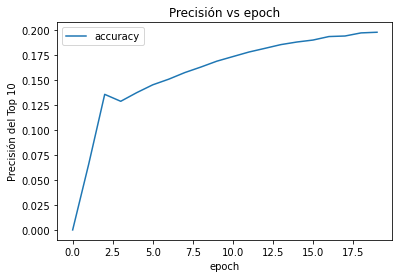

In [163]:

epochs = [i for i in range(20)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_10_categorical_accuracy"], label="accuracy")
plt.title("Precisión vs epoch")
plt.xlabel("epoch")
plt.ylabel("Precisión del Top 10");
plt.legend()


In [159]:
epochs = [i for i in range(20)]

top_5 = model_hist.history["factorized_top_k/top_5_categorical_accuracy"]
top_10 = model_hist.history["factorized_top_k/top_10_categorical_accuracy"]
top_50 = model_hist.history["factorized_top_k/top_50_categorical_accuracy"]
top_100 = model_hist.history["factorized_top_k/top_100_categorical_accuracy"]

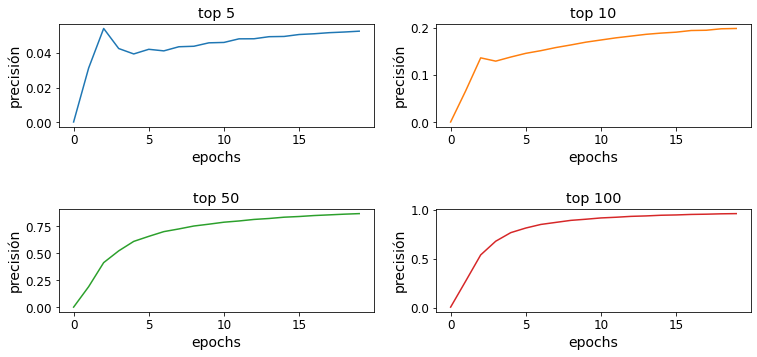

In [184]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(epochs, top_5)
axs[0, 0].set_title('top 5')
axs[0, 1].plot(epochs, top_10, 'tab:orange')
axs[0, 1].set_title('top 10')
axs[1, 0].plot(epochs, top_50, 'tab:green')
axs[1, 0].set_title('top 50')
axs[1, 1].plot(epochs, top_100, 'tab:red')
axs[1, 1].set_title('top 100')

for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='precisión')

    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.8)
plt.show()

## Evaluación con el test set
Ahora se procede a predecir los artículos más recomendados para los usuarios utilizando el **test set** que se ha separado. Con esto, determinaremos que tanto acertaría el modelo si estuviese en producción. Se utiliza `BruteForce layer`, el cual considera todos los artículos disponibles para los usuarios.

In [153]:
# Primero creamos un modelo que tome las características del raw
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model)

In [154]:
index.index_from_dataset(
    articles.batch(100).map(lambda article_id: (article_id, model.article_model(article_id))))


Posteriormente se verifica para cada usuario si el artículo que ha comprado y se encuentra en el test set (el cual no se ha utilizado para entrenar el modelo) se encuentra entre el top 10 de productos recomendados.

In [155]:
c=0

for cust in HM_test.customer_id:
    a = HM_test[HM_test.customer_id==cust].article_id.values[0]
    b = str(cust)
    _,titles = index(tf.constant([cust]))
    if a in titles[0]:
        #print("usuario: ", b)
        #print("articulo: ",a)
        #print(titles[0])
        c = c+1
        if (np.mod(int(c), 5) == 0):
            print('Encontrados: ' , c)
        
          

Encontrados:  5
Encontrados:  10
Encontrados:  15
Encontrados:  20
Encontrados:  25
Encontrados:  30
Encontrados:  35
Encontrados:  40
Encontrados:  45
Encontrados:  50
Encontrados:  55
Encontrados:  60
Encontrados:  65
Encontrados:  70
Encontrados:  75
Encontrados:  80
Encontrados:  85
Encontrados:  90
Encontrados:  95
Encontrados:  100
Encontrados:  105
Encontrados:  110
Encontrados:  115
Encontrados:  120
Encontrados:  125
Encontrados:  130
Encontrados:  135
Encontrados:  140
Encontrados:  145
Encontrados:  150
Encontrados:  155
Encontrados:  160
Encontrados:  165
Encontrados:  170
Encontrados:  175
Encontrados:  180
Encontrados:  185
Encontrados:  190
Encontrados:  195
Encontrados:  200
Encontrados:  205
Encontrados:  210
Encontrados:  215
Encontrados:  220
Encontrados:  225
Encontrados:  230
Encontrados:  235
Encontrados:  240
Encontrados:  245
Encontrados:  250
Encontrados:  255
Encontrados:  260
Encontrados:  265
Encontrados:  270
Encontrados:  275
Encontrados:  280
Encontrados:

In [156]:
print("cantidad de usuarios: ",len(HM_test.customer_id))
print("cantidad de top 10 acertados: ", c)
print("{:.10%}".format(c/len(HM_test.customer_id)))

cantidad de usuarios:  13359
cantidad de top 10 acertados:  330
2.4702447788%
